In [ ]:
%pip install --upgrade --quiet tf-nightly-2.0-preview #tf-nightly

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

1.14.0


In [2]:
import pandas as pd
import datetime
print(tf.version.VERSION)
import shutil
import os

# serving inputs to model
inputs = {
    'a' : tf.keras.layers.Input(name='a', shape=(), dtype='int32'),
    'b' : tf.keras.layers.Input(name='b', shape=(), dtype='int32')
}

# feature columns based on training inputs
infc = {
    'a' : tf.feature_column.categorical_column_with_identity('a', num_buckets = 7),
    'b' : tf.feature_column.categorical_column_with_identity('b', num_buckets = 24)
}
#infc['ab'] = tf.feature_column.crossed_column([infc['a'], infc['b']], 2 )

# transformed
outfc = {
    'a' : tf.feature_column.indicator_column(infc['a']),
    'b' : tf.feature_column.indicator_column(infc['b']),
    #'ab': tf.feature_column.embedding_column(infc['ab'], 2)                                            
}

# model architecture
ds = tf.keras.layers.DenseFeatures(outfc.values())(inputs)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'a': [3, 5, 2],
    'b': [13, 15, 18]
})
y =  [3.0, 2.0, 2.0]

#shutil.rmtree('04_keras/checkpoints/', ignore_errors=True)
#checkpoint_path = "04_keras/checkpoints/nightly.cpt"
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                 save_weights_only=True,
#                                                 verbose=1)

model.fit([df['a'], df['b']], y, steps_per_epoch=1) #, callbacks=[cp_callback])
model.evaluate([df['a'], df['b']], y)

model.predict({
    'a': tf.convert_to_tensor([3]),
    'b': tf.convert_to_tensor([13])
}, steps=1)

1.14.0


W0806 00:27:55.009308 140248122287872 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0806 00:27:55.044686 140248122287872 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4207: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0806 00:27:55.045808 140248122287872 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4262: IdentityCategorical

3/3 [==============================] - 0s 81ms/sample - loss: 4.9924 - mean_squared_error: 4.9924


array([[0.10164087]], dtype=float32)

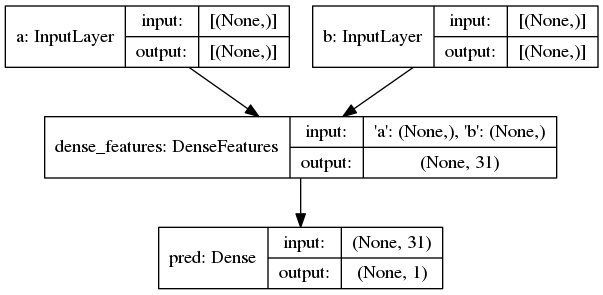

In [3]:
tf.keras.utils.plot_model(model, 'repro_model.png', show_shapes=True)

In [93]:
# demonstrates how to write a custom serving function
class ExportModel(tf.keras.Model):
    def __init__(self, model):
        super().__init__(self)
        self.model = model

    @tf.function(input_signature=[
        tf.TensorSpec([None,], dtype='int32', name='a'),
        tf.TensorSpec([None,], dtype='int32', name='b')
    ])
    def serving_fn(self, a, b):
        return {
            'pred' : self.model({'a': a, 'b': b}) #, steps=1)
        }

    def save(self, export_path):
        sigs = {
            'serving_default' : self.serving_fn
        }
        tf.keras.backend.set_learning_phase(0) # inference only
        tf.saved_model.save(self, export_path, signatures=sigs)

import shutil, os, datetime
OUTPUT_DIR = '04_keras/export/savedmodel'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))

# sm = ExportModel(model); sm.save(EXPORT_PATH)  # custom serving function
tf.saved_model.save(model, EXPORT_PATH) # with default serving function

In [94]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

The given SavedModel SignatureDef contains the following input(s):
  inputs['a'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_a:0
  inputs['b'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_b:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['pred'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [95]:
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

04_keras/export/savedmodel/20190808235300
04_keras/export/savedmodel/20190808235300/saved_model.pb
04_keras/export/savedmodel/20190808235300/assets
04_keras/export/savedmodel/20190808235300/variables
04_keras/export/savedmodel/20190808235300/variables/variables.index
04_keras/export/savedmodel/20190808235300/variables/variables.data-00000-of-00002
04_keras/export/savedmodel/20190808235300/variables/variables.data-00001-of-00002


In [21]:
%%writefile repro.json
{"a": 3, "b": 13}

Overwriting repro.json


In [97]:
%%bash
PROJECT=cloud-training-demos
BUCKET=${PROJECT}-ml
REGION=us-east1
MODEL_NAME=taxifare
VERSION_NAME=v1

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 10
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.5 --runtime-version=1.14 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

taxifare already exists
Creating taxifare:v1


In [98]:
!gcloud ai-platform predict --model taxifare --json-instances repro.json --version v1

PRED
[0.10164086520671844]


In [100]:
## REPRO for @tf.function

import tensorflow as tf
import pandas as pd
import datetime
print(tf.version.VERSION)
import shutil
import os

# serving inputs to model
inputs = {
    'pickup_datetime' : tf.keras.layers.Input(name='a', shape=(), dtype='string')
}

transformed = {}
feature_columns = {}

# hourofday can be done through a tf.strings.substr and works okay
transformed['hourofday'] = tf.keras.layers.Lambda(
        lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
        name='hourofday'
)(inputs['pickup_datetime'])
feature_columns['hourofday'] = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_identity('hourofday', num_buckets=24))

# ADDING THIS CODE CAUSES ERROR
if False:
    DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    def get_dayofweek(s):
        if type(s) is not str:
            s = s.numpy().decode('utf-8') # if it is a Tensor
        ts = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")
        return DAYS[ts.weekday()]

    print(get_dayofweek('2012-07-05 14:18:00 UTC'))
    print(get_dayofweek(tf.constant('2012-07-05 14:18:00 UTC')))

    def dayofweek(ts_in):
        return tf.map_fn(
            lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
            ts_in
        )

    transformed['dayofweek'] = tf.keras.layers.Lambda(
            lambda x: dayofweek(x),
            name='dayofweek_pyfun'
    )(inputs['pickup_datetime'])
    transformed['dayofweek'] = tf.keras.layers.Reshape((), name='dayofweek')(transformed['dayofweek'])
    feature_columns['dayofweek'] = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = DAYS))
## END ADD

# model architecture
ds = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'pickup_datetime': ['2012-07-05 14:18:00 UTC', '2012-07-05 15:18:00 UTC'],
})
y =  [3.0, 2.0]

# need clean checkpoint path: otherwise get cache error
OUTDIR='/tmp'
shutil.rmtree('{}/checkpoints/'.format(OUTDIR), ignore_errors=True)
checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit([df['pickup_datetime']], y, steps_per_epoch=1, callbacks=[cp_callback])


import shutil, os, datetime
OUTPUT_DIR = '04_keras/export/savedmodel'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH)

1.14.0

Epoch 00001: saving model to /tmp/checkpoints/taxi
1/1 [==============================] - 0s 376ms/step - loss: 5.4494 - mean_squared_error: 5.4494


In [101]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

The given SavedModel SignatureDef contains the following input(s):
  inputs['a'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_a:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['pred'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
